# Steps to run the code
[1] Place the below files in the same folder as the notebook
* prices-split-adjusted.csv
* securities.csv
* fundamentals.csv
These files can be downloaded from [kaggle](https://www.kaggle.com/dgawlik/nyse)

[2] Install the below packages
* ta-lib (using !pip install ta-lib). Please see instructions in the next cell for colab
* pandas
* numpy
* plotly
* scikit-learn
* seaborn
* graphviz
* xgboost
* matplotlib
* tensorflow
All the packages except ta-lib are available in colab by default

[3] Run all cells using "Runtime -> Run all" for colab or "Cells -> Run all" for jupyter.
This will execute all cells until LSTM training and testing.


# Install Ta-lib
Uncomment the below to install ta-lib
The first 3 lines are applicable for colab

In [6]:
#Below 3 lines are applicable for colab
#!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
#!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
#!dpkg -i libta.deb ta.deb

#!pip install ta-lib


# Import Required Packages

In [7]:
import talib as ta
import pandas as pd
import numpy as np
pd.set_option('max_columns', None)

In [8]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import decomposition

import graphviz
import xgboost as xgb
import warnings
import datetime

In [9]:
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# EDA

## Securities file

In [10]:
securities_df =pd.read_csv("securities.csv")

In [11]:
securities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Ticker symbol            505 non-null    object
 1   Security                 505 non-null    object
 2   SEC filings              505 non-null    object
 3   GICS Sector              505 non-null    object
 4   GICS Sub Industry        505 non-null    object
 5   Address of Headquarters  505 non-null    object
 6   Date first added         307 non-null    object
 7   CIK                      505 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 31.7+ KB


Quiet a few missing values in 'Date first added'

In [12]:
securities_df.describe().T

count           mean           std     min      25%       50%        75%  \
CIK  505.0  707448.966337  514437.49491  1800.0  86312.0  831001.0  1075531.0   

           max  
CIK  1659166.0

The Central Index Key (CIK) is used on the SEC's computer systems to identify corporations and individual people who have filed disclosure with the SEC and not a quantifiable metric.

In [13]:
securities_df.head()

Ticker symbol             Security SEC filings             GICS Sector  \
0           MMM           3M Company     reports             Industrials   
1           ABT  Abbott Laboratories     reports             Health Care   
2          ABBV               AbbVie     reports             Health Care   
3           ACN        Accenture plc     reports  Information Technology   
4          ATVI  Activision Blizzard     reports  Information Technology   

                GICS Sub Industry   Address of Headquarters Date first added  \
0        Industrial Conglomerates       St. Paul, Minnesota              NaN   
1           Health Care Equipment   North Chicago, Illinois       1964-03-31   
2                 Pharmaceuticals   North Chicago, Illinois       2012-12-31   
3  IT Consulting & Other Services           Dublin, Ireland       2011-07-06   
4     Home Entertainment Software  Santa Monica, California       2015-08-31   

       CIK  
0    66740  
1     1800  
2  1551152  
3  1467373  
4   718877

In [14]:
np.unique(securities_df['SEC filings'])

array(['reports'], dtype=object)

In [15]:
sectors = np.unique(securities_df['GICS Sector'])
print(sectors)

['Consumer Discretionary' 'Consumer Staples' 'Energy' 'Financials'
 'Health Care' 'Industrials' 'Information Technology' 'Materials'
 'Real Estate' 'Telecommunications Services' 'Utilities']


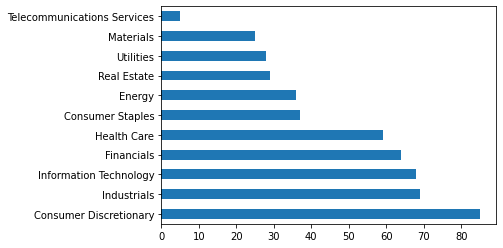

In [16]:
securities_df['GICS Sector'].value_counts().plot(kind='barh')

In [17]:
print("Number of sectors",len(np.unique(securities_df['GICS Sector'])))

Number of sectors 11


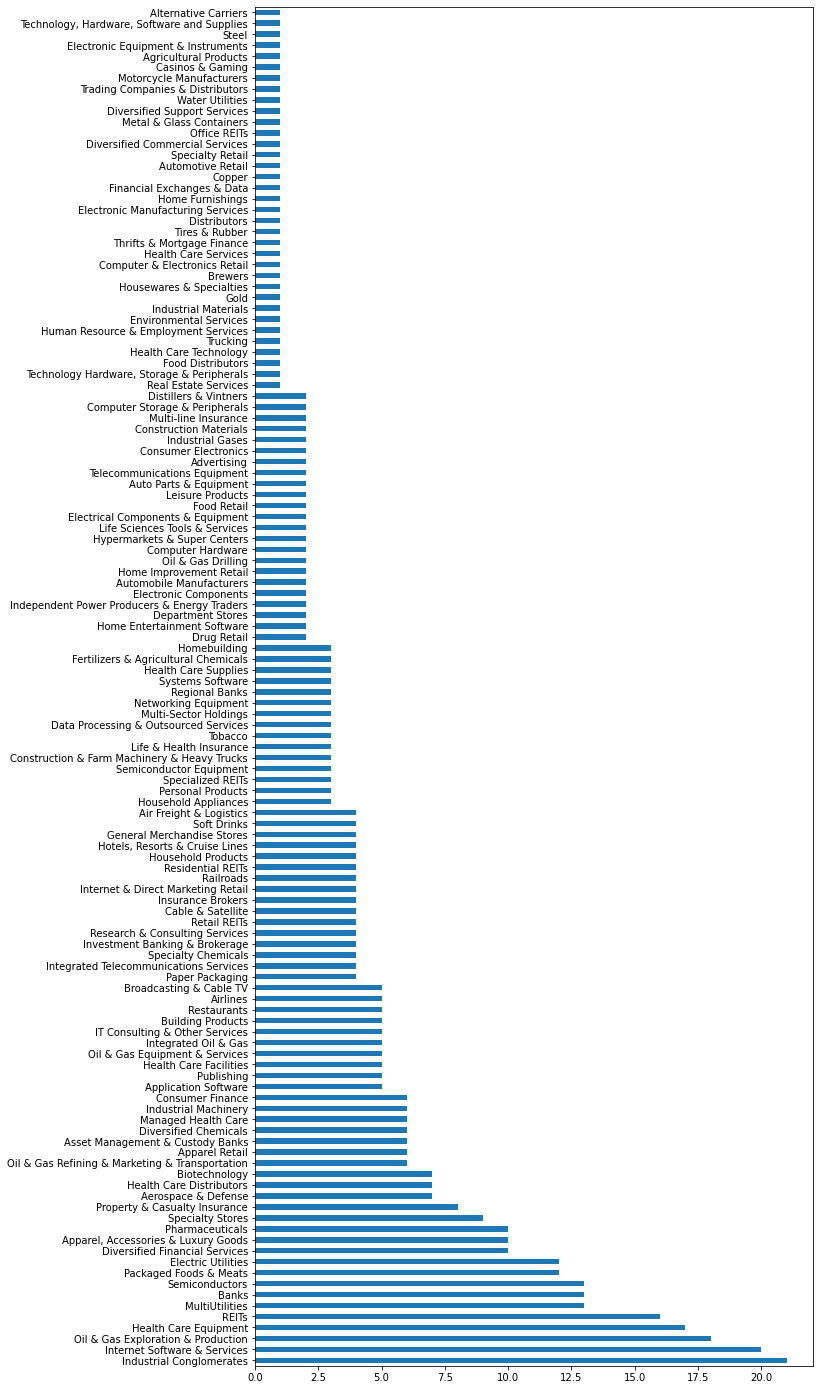

In [18]:
securities_df['GICS Sub Industry'].value_counts().plot(kind='barh',figsize=(10,25))

In [19]:
print("Number of sub industries",len(np.unique(securities_df['GICS Sub Industry'])))

Number of sub industries 124


We can use industries and sub industries to inputs to our model if required.

## Fundamentals file

In [20]:
fundamentals_df = pd.read_csv('fundamentals.csv',index_col=0)

In [21]:
fundamentals_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1781 entries, 0 to 1780
Data columns (total 78 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Ticker Symbol                                        1781 non-null   object 
 1   Period Ending                                        1781 non-null   object 
 2   Accounts Payable                                     1781 non-null   float64
 3   Accounts Receivable                                  1781 non-null   float64
 4   Add'l income/expense items                           1781 non-null   float64
 5   After Tax ROE                                        1781 non-null   float64
 6   Capital Expenditures                                 1781 non-null   float64
 7   Capital Surplus                                      1781 non-null   float64
 8   Cash Ratio                                           1482 non-null  

Cash Ratio, Quick Ratio, For Year, Earnings Per Share, Estimated Shares Outstanding have some missing values

In [22]:
print("Fundamentals are available for",len(np.unique(fundamentals_df['Ticker Symbol'])),"stocks")

Fundamentals are available for 448 stocks


We do not seen to have fundamentals details for all stocks

In [23]:
fundamentals_df.describe().T

count          mean           std  \
Accounts Payable              1781.0  4.673418e+09  1.406047e+10   
Accounts Receivable           1781.0 -6.353484e+07  7.562794e+08   
Add'l income/expense items    1781.0  6.908940e+07  6.848143e+08   
After Tax ROE                 1781.0  4.360135e+01  2.339240e+02   
Capital Expenditures          1781.0 -1.251925e+09  2.979963e+09   
...                              ...           ...           ...   
Total Revenue                 1781.0  2.029154e+10  4.095355e+10   
Treasury Stock                1781.0 -3.951522e+09  1.407047e+10   
For Year                      1608.0  2.013305e+03  1.995314e+01   
Earnings Per Share            1562.0  3.353707e+00  4.695896e+00   
Estimated Shares Outstanding  1562.0  6.024244e+08  1.142585e+09   

                                       min           25%           50%  \
Accounts Payable              0.000000e+00  5.160000e+08  1.334000e+09   
Accounts Receivable          -6.452000e+09 -1.040000e+08 -1.830000e+07   
Add'l income/expense items   -6.768000e+09 -2.638000e+06  2.000000e+06   
After Tax ROE                 0.000000e+00  1.000000e+01  1.600000e+01   
Capital Expenditures         -3.798500e+10 -1.151200e+09 -3.580000e+08   
...                                    ...           ...           ...   
Total Revenue                 1.514000e+06  3.714000e+09  8.023200e+09   
Treasury Stock               -2.297340e+11 -3.040895e+09 -3.068350e+08   
For Year                      1.215000e+03  2.013000e+03  2.014000e+03   
Earnings Per Share           -6.120000e+01  1.590000e+00  2.810000e+00   
Estimated Shares Outstanding -1.513945e+09  1.493318e+08  2.929409e+08   

                                       75%           max  
Accounts Payable              3.246000e+09  2.069390e+11  
Accounts Receivable           7.816000e+06  2.266400e+10  
Add'l income/expense items    3.359200e+07  1.416200e+10  
After Tax ROE                 2.600000e+01  5.789000e+03  
Capital Expenditures         -1.291000e+08  5.000000e+06  
...                                    ...           ...  
Total Revenue                 1.748600e+10  4.856510e+11  
Treasury Stock                0.000000e+00  0.000000e+00  
For Year                      2.015000e+03  2.016000e+03  
Earnings Per Share            4.590000e+00  5.009000e+01  
Estimated Shares Outstanding  5.492163e+08  1.610769e+10  

[76 rows x 8 columns]

In [24]:
fundamentals_df.head()

Ticker Symbol Period Ending  Accounts Payable  Accounts Receivable  \
0           AAL    2012-12-31      3.068000e+09         -222000000.0   
1           AAL    2013-12-31      4.975000e+09          -93000000.0   
2           AAL    2014-12-31      4.668000e+09         -160000000.0   
3           AAL    2015-12-31      5.102000e+09          352000000.0   
4           AAP    2012-12-29      2.409453e+09          -89482000.0   

   Add'l income/expense items  After Tax ROE  Capital Expenditures  \
0               -1.961000e+09           23.0         -1.888000e+09   
1               -2.723000e+09           67.0         -3.114000e+09   
2               -1.500000e+08          143.0         -5.311000e+09   
3               -7.080000e+08          135.0         -6.151000e+09   
4                6.000000e+05           32.0         -2.711820e+08   

   Capital Surplus  Cash Ratio  Cash and Cash Equivalents  \
0     4.695000e+09        53.0               1.330000e+09   
1     1.059200e+10        75.0               2.175000e+09   
2     1.513500e+10        60.0               1.768000e+09   
3     1.159100e+10        51.0               1.085000e+09   
4     5.202150e+08        23.0               5.981110e+08   

   Changes in Inventories  Common Stocks  Cost of Revenue  Current Ratio  \
0                     0.0    127000000.0     1.049900e+10           78.0   
1                     0.0      5000000.0     1.101900e+10          104.0   
2                     0.0      7000000.0     1.562000e+10           88.0   
3                     0.0      6000000.0     1.109600e+10           73.0   
4            -260298000.0         7000.0     3.106967e+09          124.0   

   Deferred Asset Charges  Deferred Liability Charges  Depreciation  \
0            0.000000e+00                 223000000.0  1.001000e+09   
1            0.000000e+00                 935000000.0  1.020000e+09   
2            0.000000e+00                 829000000.0  1.342000e+09   
3            2.477000e+09                 667000000.0  1.487000e+09   
4            0.000000e+00                         0.0  1.895440e+08   

   Earnings Before Interest and Tax  Earnings Before Tax  \
0                     -1.813000e+09        -2.445000e+09   
1                     -1.324000e+09        -2.180000e+09   
2                      4.099000e+09         3.212000e+09   
3                      5.496000e+09         4.616000e+09   
4                      6.579150e+08         6.240740e+08   

   Effect of Exchange Rate  Equity Earnings/Loss Unconsolidated Subsidiary  \
0                      0.0                                             0.0   
1                      0.0                                             0.0   
2                      0.0                                             0.0   
3                      0.0                                             0.0   
4                      0.0                                             0.0   

   Fixed Assets      Goodwill  Gross Margin  Gross Profit    Income Tax  \
0  1.340200e+10  0.000000e+00          58.0  1.435600e+10 -5.690000e+08   
1  1.925900e+10  4.086000e+09          59.0  1.572400e+10 -3.460000e+08   
2  2.308400e+10  4.091000e+09          63.0  2.703000e+10  3.300000e+08   
3  2.751000e+10  4.091000e+09          73.0  2.989400e+10 -2.994000e+09   
4  1.292547e+09  7.638900e+07          50.0  3.098036e+09  2.364040e+08   

   Intangible Assets  Interest Expense     Inventory   Investments  \
0       8.690000e+08       632000000.0  5.800000e+08  3.060000e+08   
1       2.311000e+09       856000000.0  1.012000e+09 -1.181000e+09   
2       2.240000e+09       887000000.0  1.004000e+09  1.799000e+09   
3       2.249000e+09       880000000.0  8.630000e+08  4.430000e+08   
4       2.884500e+07        33841000.0  2.308609e+09  0.000000e+00   

    Liabilities  Long-Term Debt  Long-Term Investments  Minority Interest  \
0  4.730000e+08    7.116000e+09                    0.0                0.0   
1 -2.350000e+08    1.535300e+10          

In [25]:
stock_year_size = fundamentals_df.groupby(['Ticker Symbol','For Year']).size()

#Checking for stocks with multiple years
multiple_year = stock_year_size[stock_year_size != 1]#.to_frame()

In [26]:
print("Below stocks have multiple values for a given year:")
print(multiple_year)
print("-"*100)


Below stocks have multiple values for a given year:
Ticker Symbol  For Year
ANTM           2013.0      2
EIX            2012.0      2
KORS           2013.0      2
R              2013.0      2
RCL            2014.0      2
SE             2014.0      2
dtype: int64
----------------------------------------------------------------------------------------------------


In [27]:
#Uncomment below to print the ones with multiple values
'''
for index, value in multiple_year.items():
  print(fundamentals_df[(fundamentals_df['Ticker Symbol'] == index[0]) & (fundamentals_df['For Year'] == index[1]) ])
  print("-"*100)'''

'\nfor index, value in multiple_year.items():\n  print(fundamentals_df[(fundamentals_df[\'Ticker Symbol\'] == index[0]) & (fundamentals_df[\'For Year\'] == index[1]) ])\n  print("-"*100)'

6 stocks have fundamental data for duplicate years, this needs to be dealt, hence dropping duplicates

In [28]:
fundamentals_df.drop_duplicates(['Ticker Symbol','For Year'],inplace=True)

## Adjusted prices

In [29]:
price_split_adj_df = pd.read_csv("prices-split-adjusted.csv")#, index_col = 0)
print(price_split_adj_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB
None


In [30]:
print(price_split_adj_df.head())

         date symbol        open       close         low        high  \
0  2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0  


In [31]:
# number of different stocks
unique_stocks = list(set(price_split_adj_df.symbol))
print('number of different stocks: ', len(unique_stocks))

number of different stocks:  501


In [32]:
price_split_adj_df.dropna(inplace=True) #dropping NA if any

In [33]:
#Checking if all stock names are present in securities
np.all(np.in1d(np.unique(price_split_adj_df.symbol), np.unique(securities_df['Ticker symbol'])))

True

All stock names in price adjusted file are present in securitites file

In [34]:
#Checking if all stock names are present in securities
np.all(np.in1d(np.unique(price_split_adj_df.symbol), np.unique(fundamentals_df['Ticker Symbol'])))

False

All stock names in price adjusted file are **not** present in fundamentals file.

In [35]:
print("below stock details are not present in fundamentals file")
np.unique(price_split_adj_df[~price_split_adj_df['symbol'].isin(fundamentals_df['Ticker Symbol'])]['symbol'])

below stock details are not present in fundamentals file


array(['A', 'ACN', 'ADP', 'AES', 'AET', 'AGN', 'BEN', 'BLK', 'CA', 'CBS',
       'CMCSA', 'COH', 'COP', 'DOW', 'DTE', 'ENDP', 'ESRX', 'EVHC',
       'FITB', 'FOX', 'FOXA', 'FTI', 'FTV', 'GE', 'GOOG', 'GOOGL', 'GS',
       'ICE', 'IR', 'JCI', 'JNJ', 'KHC', 'L', 'LNC', 'MDT', 'MNK', 'MSI',
       'NI', 'NOC', 'NRG', 'ORCL', 'PLD', 'PRGO', 'PSA', 'PXD', 'RAI',
       'RF', 'RIG', 'RTN', 'SLB', 'TROW', 'TWX', 'URI', 'WBA'],
      dtype=object)

We might be able to use external data and supplement this

In [36]:
price_split_adj_df.describe().T

count          mean           std   min           25%  \
open    851264.0  6.499362e+01  7.520389e+01  1.66  3.127000e+01   
close   851264.0  6.501191e+01  7.520122e+01  1.59  3.129278e+01   
low     851264.0  6.433654e+01  7.445952e+01  1.50  3.094000e+01   
high    851264.0  6.563975e+01  7.590686e+01  1.81  3.162000e+01   
volume  851264.0  5.415113e+06  1.249468e+07  0.00  1.221500e+06   

                 50%           75%           max  
open    4.846000e+01  7.512000e+01  1.584440e+03  
close   4.848000e+01  7.514000e+01  1.578130e+03  
low     4.797000e+01  7.440000e+01  1.549940e+03  
high    4.896000e+01  7.585000e+01  1.600930e+03  
volume  2.476250e+06  5.222500e+06  8.596434e+08

In [37]:
#Commenting this block as its execution takes a couple of seconds

#print("Data for all stocks except the below are available for the years - '2010','2011','2012','2013','2014','2015','2016'")
#price_split_adj_df_tmp = price_split_adj_df
#price_split_adj_df_tmp['year'] = price_split_adj_df['date'].apply(lambda x: x.split("-")[0])
#for eachstock in np.unique(price_split_adj_df.symbol):
#  available_years = np.sort(np.unique(price_split_adj_df_tmp[price_split_adj_df_tmp['symbol']==eachstock].year))
#  if not np.all(np.in1d( ['2010','2011','2012','2013','2014','2015','2016'],available_years)):
#    print(eachstock,available_years)

In [38]:
#adding sector and sub sector to stocks data


price_split_enhannced_df = price_split_adj_df.merge(securities_df[['Ticker symbol','GICS Sector','GICS Sub Industry']], how='left', left_on="symbol", right_on="Ticker symbol")
price_split_enhannced_df.drop(['Ticker symbol'],axis=1,inplace=True)
price_split_enhannced_df.head()

date symbol        open       close         low        high  \
0  2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume GICS Sector  GICS Sub Industry  
0  2163600.0  Financials  Insurance Brokers  
1  2386400.0  Financials  Insurance Brokers  
2  2489500.0  Financials  Insurance Brokers  
3  2006300.0  Financials  Insurance Brokers  
4  1408600.0  Financials  Insurance Brokers

## Function for EDA of a stock

In [39]:
def eda_per_stock(data_,stockname):
  """Performs EDA and created visualisation of a given stock
  
  Args-
    data_ - This is the dataset containing adjusted prices information for all S&P 500 stocks
    stockname - Name of the stock i.e. symbol for which EDA is required. Example - AMZN
  
  Function-
    1. Creates interactive OHLC chart
    2. Creates line graph and PDF of difference of Open Prices
    3. Creates line graph and PDF of difference of Close Prices
    4. Regression and correlation among different combinations of Open, High, Low, Close & Volumne features
  """

  security_name = securities_df[securities_df['Ticker symbol'] ==stockname]['Security'].values[0] #Fetch stock name from securities file

  EQIX_Stock_data = data_[data_.symbol == stockname]
  EQIX_Stock_data.index =  EQIX_Stock_data['date']

  #Creating OHLC interactive plot
  fig = go.Figure(layout=go.Layout(title=go.layout.Title(text="OHLC prices of "+security_name))) 
  for each_ohlc in ['open','close','low','high']:
      fig.add_trace(go.Scatter(x=EQIX_Stock_data.index, y=EQIX_Stock_data[each_ohlc],mode='lines',name=each_ohlc))

  # Show plot
  print("Stock name -",stockname)
  print("Sector -",securities_df[securities_df['Ticker symbol'] ==stockname]['GICS Sector'].values[0])
  print("Sub Sector -",securities_df[securities_df['Ticker symbol'] ==stockname]['GICS Sub Industry'].values[0])
  fig.show()

  fig = make_subplots(rows=1, cols=2, column_widths=[0.6, 0.4],subplot_titles=("Difference of Open price", "Probability density of Open price difference"))

  fig.add_trace(go.Scatter(x= EQIX_Stock_data.index, y=EQIX_Stock_data.open.diff(), name='l1'),row=1, col=1)

  fig.add_trace(go.Histogram(x=EQIX_Stock_data['open'].diff(), name='h1', histnorm='probability density'),row=1, col=2)
  fig.update_layout( height=550, width=1130, title_text="Consecutive difference between opening stock price of "+security_name+" shares")

  fig.update_xaxes(title_text="Time", row=1, col=1)
  fig.update_xaxes(title_text="Value", row=1, col=2)
  fig.update_yaxes(title_text="Value", row=1, col=1)
  fig.update_yaxes(title_text="Prob. Density", row=1, col=2)

  fig.show()

  fig = make_subplots(rows=1, cols=2, column_widths=[0.6, 0.4],subplot_titles=("Difference of Close price", "Probability density of Close price difference"))

  fig.add_trace(go.Scatter(x= EQIX_Stock_data.index, y=EQIX_Stock_data.close.diff(), name='l1'),row=1, col=1)

  fig.add_trace(go.Histogram(x=EQIX_Stock_data['close'].diff(), name='h1', histnorm='probability density'),row=1, col=2)
  fig.update_layout( height=550, width=1130, title_text="Consecutive difference between closing stock price of "+security_name+" shares")

  fig.update_xaxes(title_text="Time", row=1, col=1)
  fig.update_xaxes(title_text="Value", row=1, col=2)
  fig.update_yaxes(title_text="Value", row=1, col=1)
  fig.update_yaxes(title_text="Prob. Density", row=1, col=2)

  fig.show()


  f, axes= plt.subplots(2,2, figsize=(20,14))
  sns.regplot(x=EQIX_Stock_data.open, y=EQIX_Stock_data.close, color="g", ax=axes[0][0])
  axes[0][0].title.set_text('Linear Regression between Open and Close for '+security_name+' stock')
  sns.regplot(x=EQIX_Stock_data.open, y=EQIX_Stock_data.volume, ax=axes[0][1])
  axes[0][1].title.set_text('Linear Regression between Open and Volume for '+security_name+' stock')
  sns.regplot(x=EQIX_Stock_data.low, y=EQIX_Stock_data.high, color="b", ax=axes[1][0])
  axes[1][0].title.set_text('Linear Regression between Low and High for '+security_name+' stock')
  sns.regplot(x=EQIX_Stock_data.volume, y=EQIX_Stock_data.close, color="g", ax=axes[1][1])
  axes[1][1].title.set_text('Linear Regression between Volume and Close for '+security_name+' stock')
  #f.update_layout(title_text="Consecutive difference between opening stock price of "+security_name+" shares")

  f.show()

  f, axes= plt.subplots(1,2, figsize=(20,6))
  sns.regplot(x=EQIX_Stock_data.open.diff(), y=EQIX_Stock_data.close.diff(), color="g", ax=axes[0])
  sns.regplot(x=EQIX_Stock_data.low.diff(), y=EQIX_Stock_data.high.diff(), color="b", ax=axes[1])
  plt.suptitle('Consecutive variation correlations for '+security_name, size=16)
  plt.show()

  corr= EQIX_Stock_data.corr()
  plt.figure(figsize=(8,5))
  plt.title("Heat map for correlation for "+security_name)
  sns.heatmap(corr, annot=True, cmap="Greens_r",linewidth = 3, linecolor = "white")
  plt.show()
  print("EDA complete for "+security_name)
  print("-"*140)



Stock name - AMZN
Sector - Consumer Discretionary
Sub Sector - Internet & Direct Marketing Retail


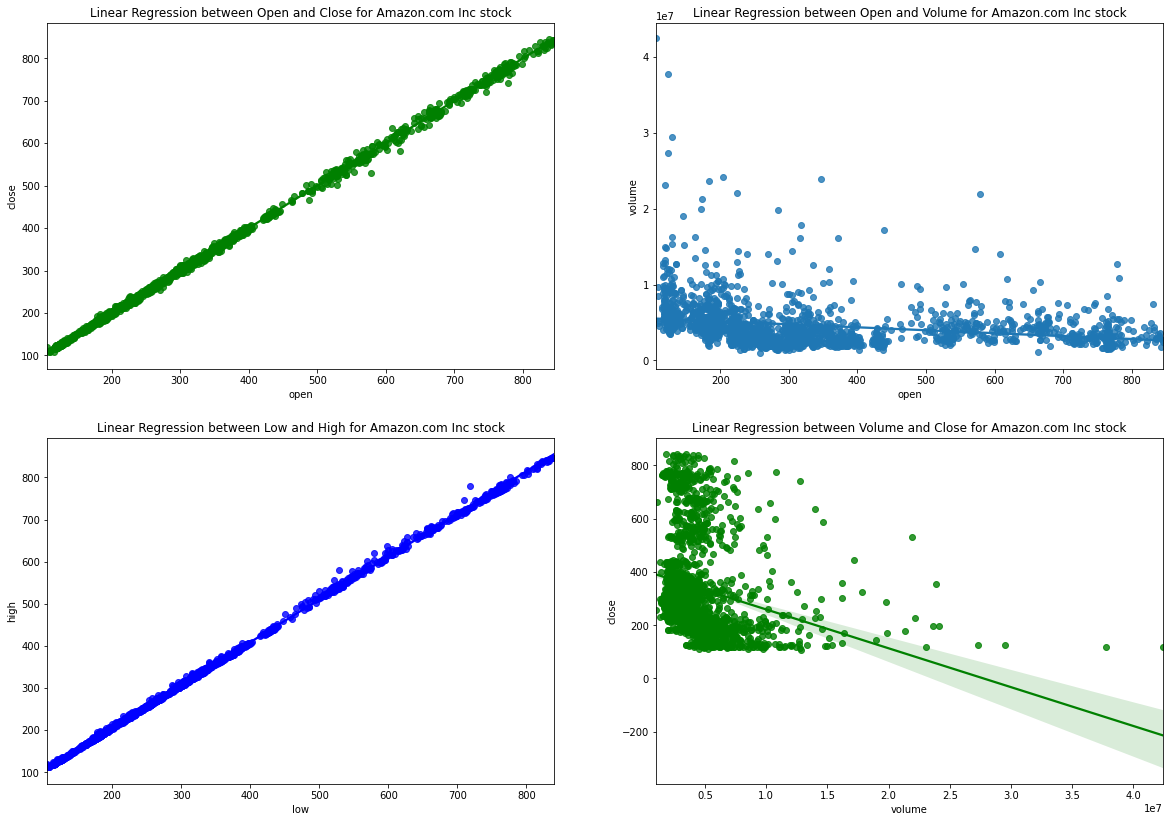

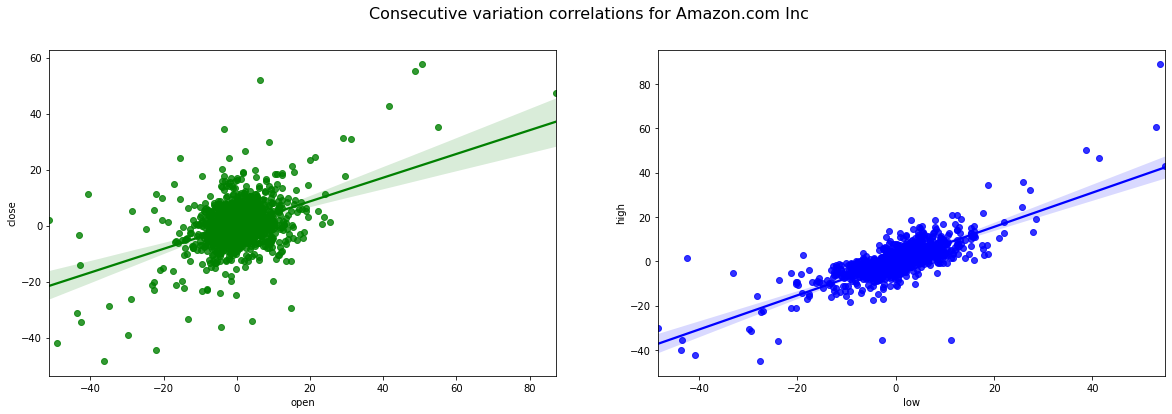

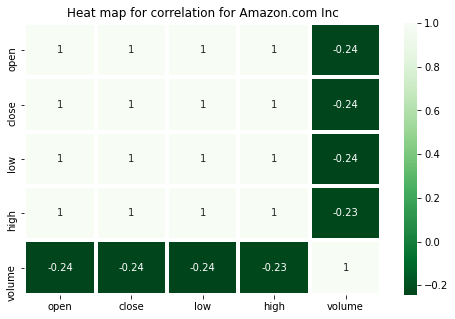

EDA complete for Amazon.com Inc
--------------------------------------------------------------------------------------------------------------------------------------------


In [40]:
eda_per_stock(price_split_adj_df,'AMZN') #Viewing information of AMAZON stock

# Data preprocessing

In [41]:
price_split_enhannced_df.head()

date symbol        open       close         low        high  \
0  2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume GICS Sector  GICS Sub Industry  
0  2163600.0  Financials  Insurance Brokers  
1  2386400.0  Financials  Insurance Brokers  
2  2489500.0  Financials  Insurance Brokers  
3  2006300.0  Financials  Insurance Brokers  
4  1408600.0  Financials  Insurance Brokers

In [42]:
UniqueStockNames = price_split_enhannced_df.symbol.unique()

#create a data frame dictionary to store dataframe of individual stock
stockprices_Dict = {elem : pd.DataFrame for elem in UniqueStockNames}

#Splitting the entire prices data into chunks and storing into dictionary to make preprocessing easier per stock
#We might be able to do this for only the stocks we want
for key in stockprices_Dict.keys():
    stockprices_Dict[key] = price_split_enhannced_df[:][price_split_enhannced_df.symbol == key]
    stockprices_Dict[key].reset_index(drop=True,inplace=True)  
    stockprices_Dict[key]['LogReturnClose'] =np.log(stockprices_Dict[key].close) - np.log(stockprices_Dict[key].close.shift(1)) #Adding log return
    stockprices_Dict[key]['LogReturnOpen'] =np.log(stockprices_Dict[key].open) - np.log(stockprices_Dict[key].open.shift(1)) #Adding log return
    stockprices_Dict[key]['LogReturnLow'] =np.log(stockprices_Dict[key].low) - np.log(stockprices_Dict[key].low.shift(1)) #Adding log return
    stockprices_Dict[key]['LogReturnHigh'] =np.log(stockprices_Dict[key].high) - np.log(stockprices_Dict[key].high.shift(1)) #Adding log return
    #Some technical indicators from talib
    # Create technical return and add to stocks dictionary
    stockprices_Dict[key]['MA'] = ta.SMA(stockprices_Dict[key]['close'],20)
    stockprices_Dict[key]['EMA'] = ta.EMA(stockprices_Dict[key]['close'], timeperiod = 20)
    stockprices_Dict[key]['Relative'] = ta.RSI(stockprices_Dict[key]['close'],14)
    stockprices_Dict[key]['BB_upper'] = ta.BBANDS(stockprices_Dict[key]['close'],20,2,2)[0]
    stockprices_Dict[key]['BB_middle'] = ta.BBANDS(stockprices_Dict[key]['close'],20,2,2)[1]
    stockprices_Dict[key]['BB_lower'] = ta.BBANDS(stockprices_Dict[key]['close'],20,2,2)[2]
    stockprices_Dict[key]['TEMA'] = ta.TEMA(stockprices_Dict[key]['close'])
    stockprices_Dict[key]['MACD'] = ta.MACD(stockprices_Dict[key]['close'])[1]
    stockprices_Dict[key]['MOM'] = ta.MOM(stockprices_Dict[key]['close'])
    stockprices_Dict[key]['WILLR'] = ta.WILLR(stockprices_Dict[key]['high'], stockprices_Dict[key]['low'], stockprices_Dict[key]['close'])

TA_keynames = ['MA','EMA','Relative','BB_upper','BB_middle','BB_lower','TEMA','MACD','MOM','WILLR'] #columns names of TA to use in preprocessing prior ro regression

### Identify Five Largest Stocks Per Sector
Intention: Use these as indicators of sector performance which can help make predictions.  
Use common stocks x price to get market cap.  
Other metrics to consider = After Tax ROE


In [43]:
price_split_enhannced_df['date'] = pd.to_datetime(price_split_enhannced_df.date)
price_split_enhannced_df['year'] = price_split_enhannced_df.date.dt.year    

In [44]:
fundamentals_sub = fundamentals_df[['Ticker Symbol', 'For Year','Common Stocks']]
fundamentals_sub.columns=['symbol','year','Common Stocks']
fundamentals_df = fundamentals_sub.merge(price_split_enhannced_df, how='left', on=['symbol','year'])
fundamentals_df['mkt cap'] = fundamentals_df['Common Stocks'] * fundamentals_df['close']

fundamentals_df = fundamentals_df.drop(labels=['Common Stocks'], axis=1)
price_split_enhannced_df = price_split_enhannced_df.drop(labels=['year'], axis=1)    

fundamentals_df.head()

symbol    year       date  open  close   low  high     volume  GICS Sector  \
0    AAL  2012.0 2012-01-03  5.20   5.12  5.07  5.22  6105900.0  Industrials   
1    AAL  2012.0 2012-01-04  5.09   5.03  4.97  5.18  5268700.0  Industrials   
2    AAL  2012.0 2012-01-05  5.15   5.47  5.07  5.48  8216100.0  Industrials   
3    AAL  2012.0 2012-01-06  5.44   5.60  5.40  5.67  8323000.0  Industrials   
4    AAL  2012.0 2012-01-09  5.56   5.72  5.55  5.80  8029900.0  Industrials   

  GICS Sub Industry      mkt cap  
0          Airlines  650240000.0  
1          Airlines  638810000.0  
2          Airlines  694690000.0  
3          Airlines  711200000.0  
4          Airlines  726440000.0

In [45]:
largest_sector_stocks = {}
def arrange_mk_cap(sector):
  for sect in sectors:
    print(sect)
    df = fundamentals_df[fundamentals_df['GICS Sector']==sect]
    years = np.unique(df.year)
    df = df.sort_values(by='mkt cap', ascending=False)
    df = df.drop_duplicates(subset=['symbol', 'year'], keep='first')
    df = df.reset_index(drop=True)
    largest_sector_stocks[sect] = df
  return largest_sector_stocks

In [46]:
largest_sector_stocks = arrange_mk_cap(sectors) #Saving largest stock details in dictionary

Consumer Discretionary
Consumer Staples
Energy
Financials
Health Care
Industrials
Information Technology
Materials
Real Estate
Telecommunications Services
Utilities


### Add Correlated Stocks within Sector
Per sector get the correlation of the largest stock (which will be y) with the next three largest stocks in the sector.  
Using 30 day rolling correlation

Get the largest stock per sector and the next largest 3 stocks in the same sector

In [47]:
stocks_by_sector = {}
stocks_for_y = {}
def sector_largest(sectors):
  for sect in sectors:
    largest_stocks = largest_sector_stocks[sect]
    largest_stock = largest_stocks[largest_stocks.year == max(largest_stocks.year)]
    largest_stock = largest_stock.sort_values(by='mkt cap', ascending=False)
    largest_stock = largest_stock.reset_index(drop=True)
    largest_stock = largest_stock.symbol[0]
    stocks_for_y[sect] = largest_stock
    other_stocks = np.unique(largest_sector_stocks[sect].symbol)[1:4]
    stocks_by_sector[sect] = [largest_stock]
    stocks_by_sector[sect].append(list(other_stocks))
  return stocks_by_sector, stocks_for_y

stocks_by_sector, stocks_for_y = sector_largest(sectors)

In [48]:
stock_correlations = {}
for sect in sectors:
  stock = stocks_by_sector[sect][0]
  others = stocks_by_sector[sect][1]
  stock_correlations[sect] = stockprices_Dict[stock].close
  for idx,i in enumerate(others):
    stockprices_Dict[stock][(str(idx)+'_corr')] = stockprices_Dict[stock].close.rolling(30).corr(stockprices_Dict[i].close)

Stocks to regress on:

In [49]:
stocks_for_y

{'Consumer Discretionary': 'DIS',
 'Consumer Staples': 'CAG',
 'Energy': 'HP',
 'Financials': 'HRB',
 'Health Care': 'CAH',
 'Industrials': 'DE',
 'Information Technology': 'MSFT',
 'Materials': 'APD',
 'Real Estate': 'O',
 'Telecommunications Services': 'T',
 'Utilities': 'EXC'}

## EDA for identified stocks

Stock name - DIS
Sector - Consumer Discretionary
Sub Sector - Broadcasting & Cable TV


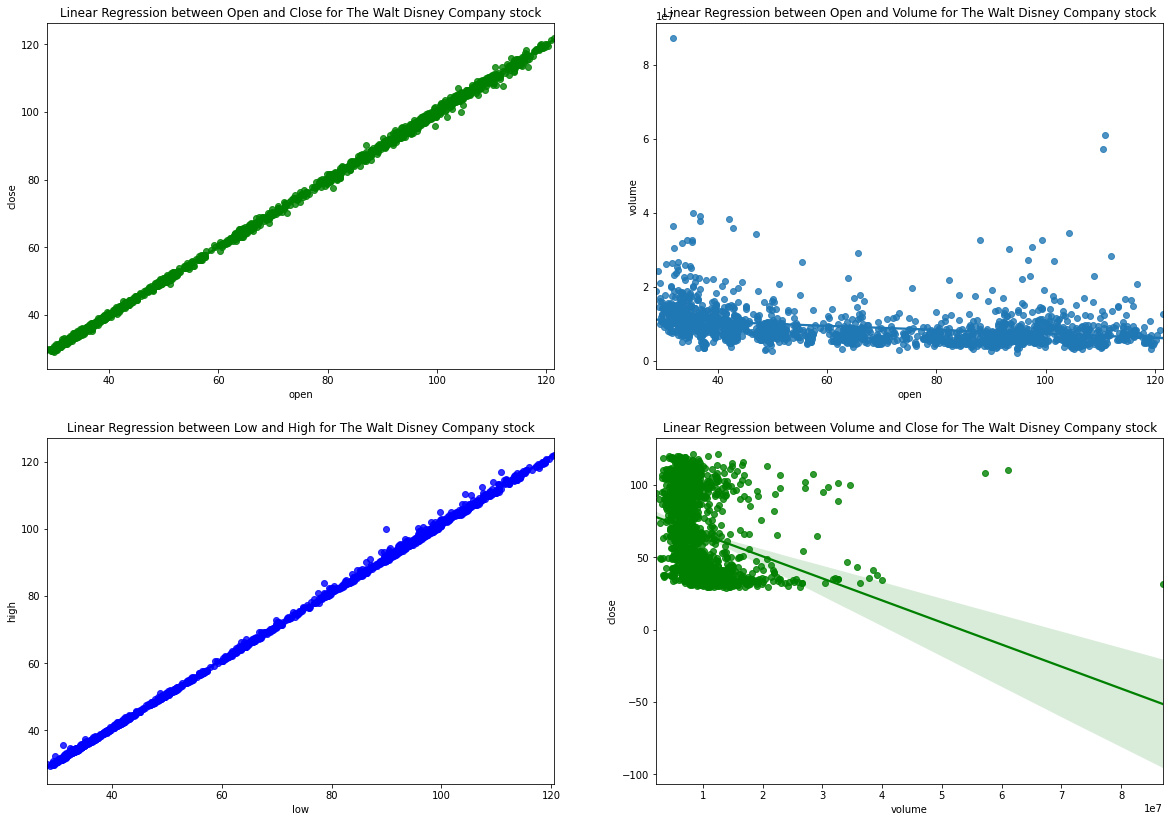

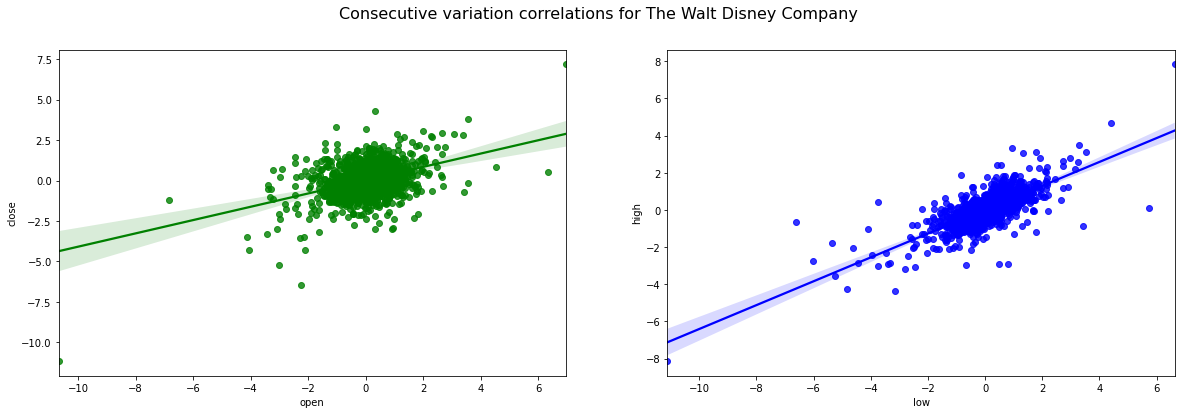

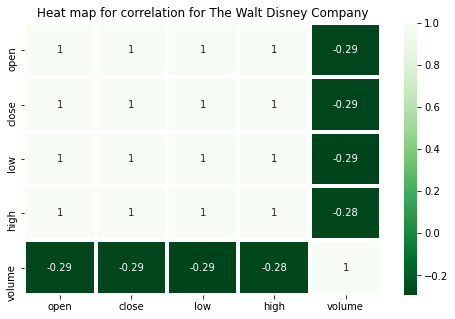

EDA complete for The Walt Disney Company
--------------------------------------------------------------------------------------------------------------------------------------------
Stock name - CAG
Sector - Consumer Staples
Sub Sector - Packaged Foods & Meats


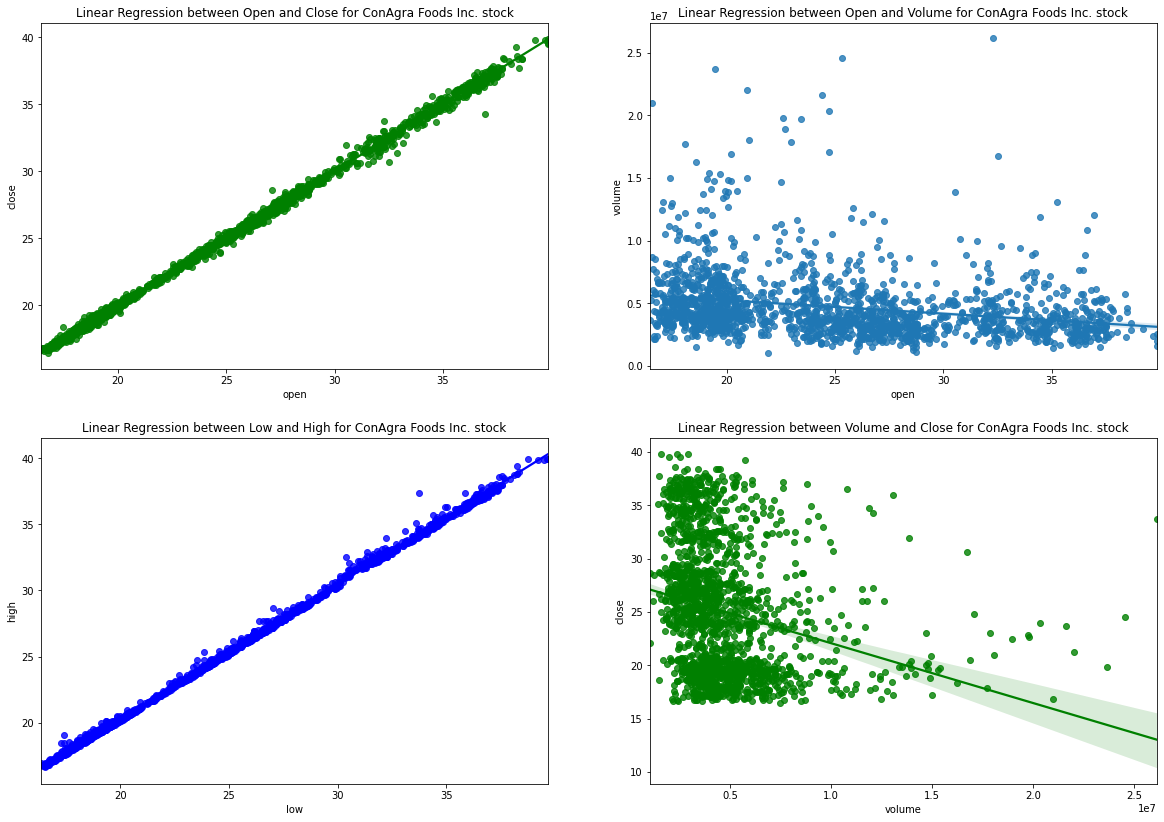

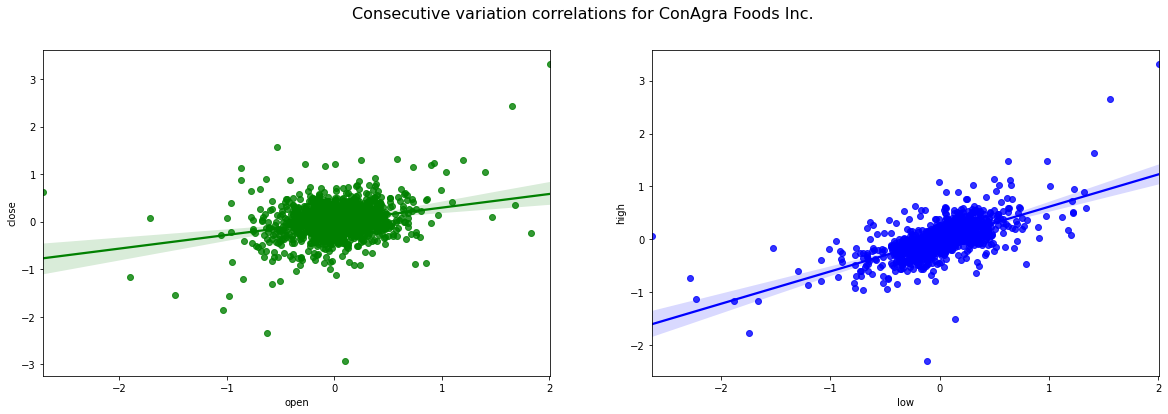

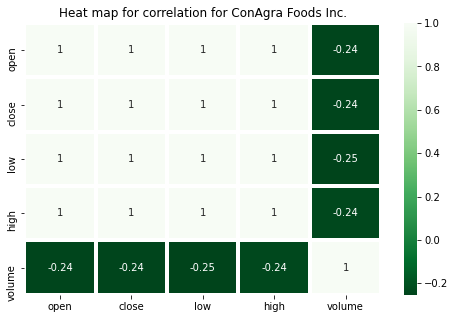

EDA complete for ConAgra Foods Inc.
--------------------------------------------------------------------------------------------------------------------------------------------
Stock name - HP
Sector - Energy
Sub Sector - Oil & Gas Drilling


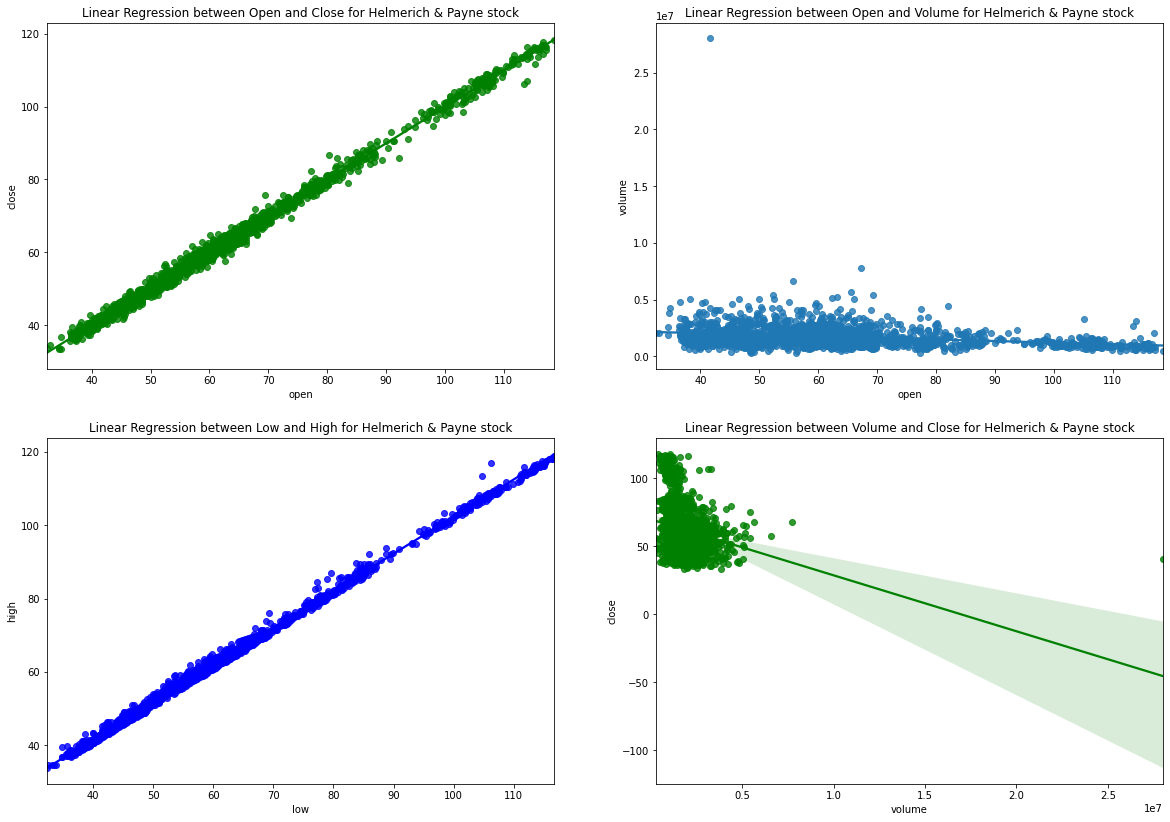

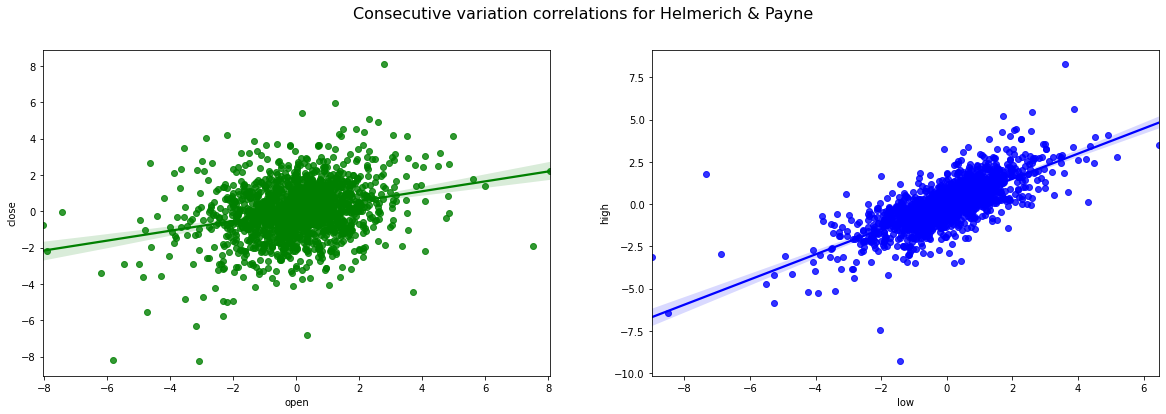

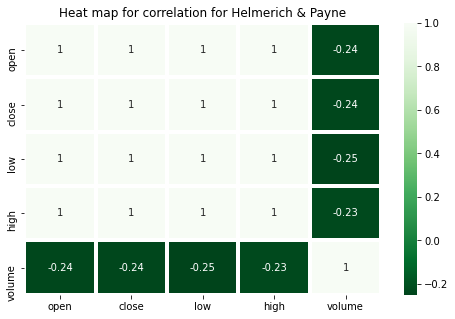

EDA complete for Helmerich & Payne
--------------------------------------------------------------------------------------------------------------------------------------------
Stock name - HRB
Sector - Financials
Sub Sector - Consumer Finance


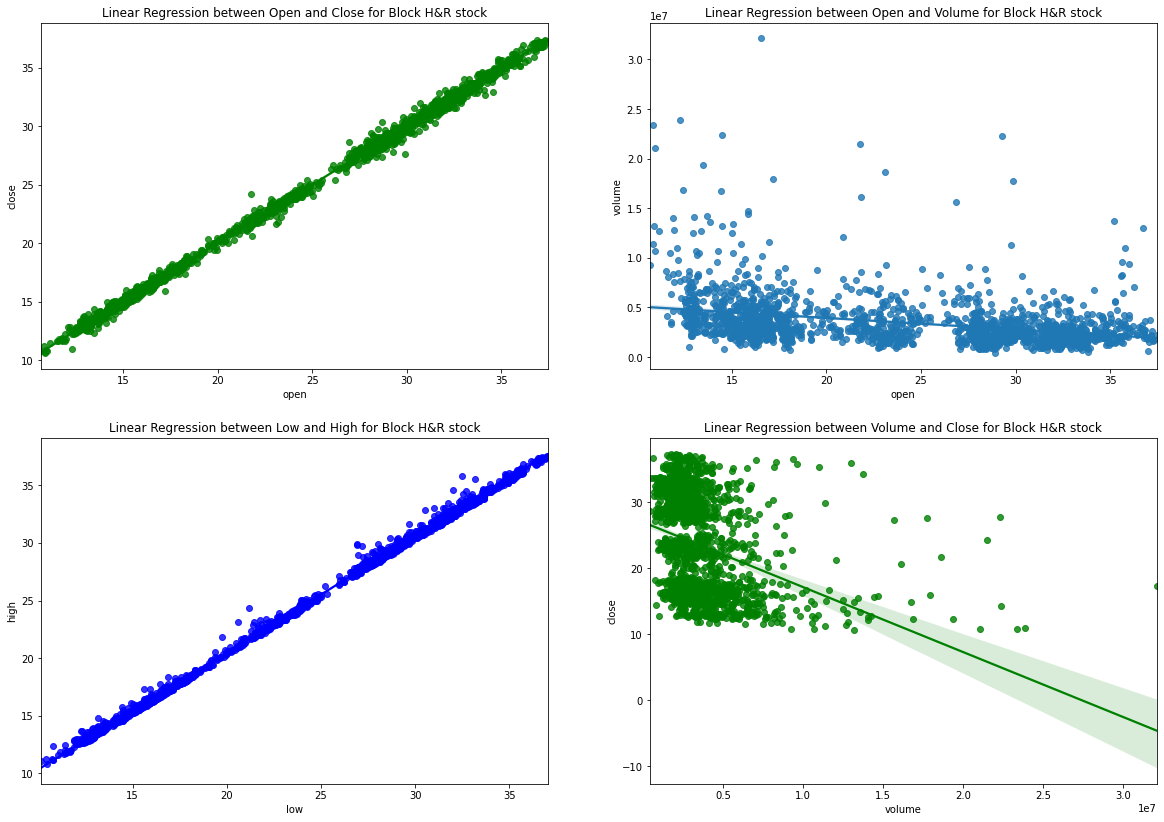

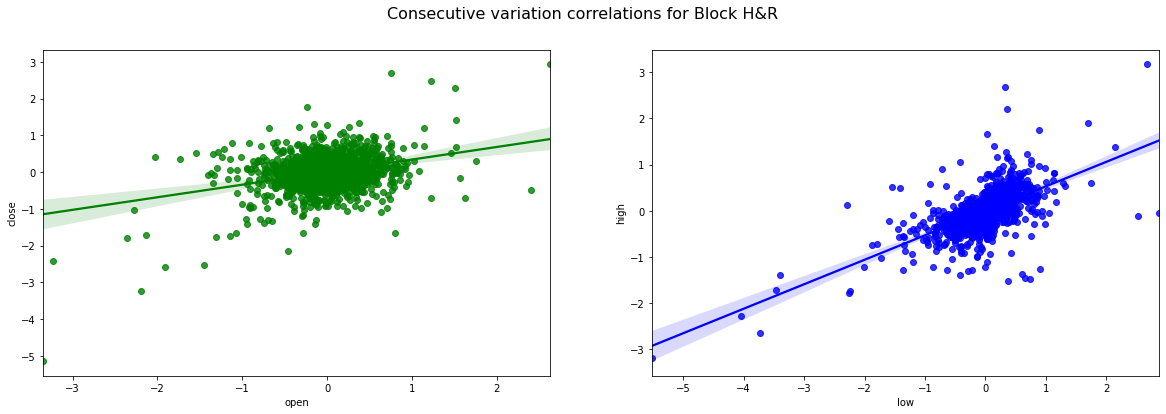

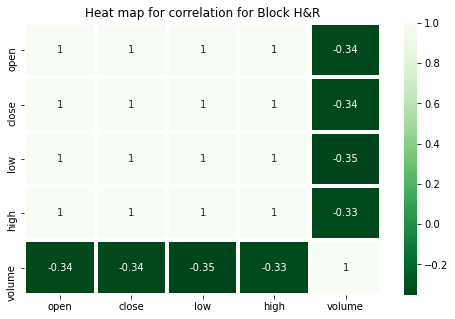

EDA complete for Block H&R
--------------------------------------------------------------------------------------------------------------------------------------------
Stock name - CAH
Sector - Health Care
Sub Sector - Health Care Distributors


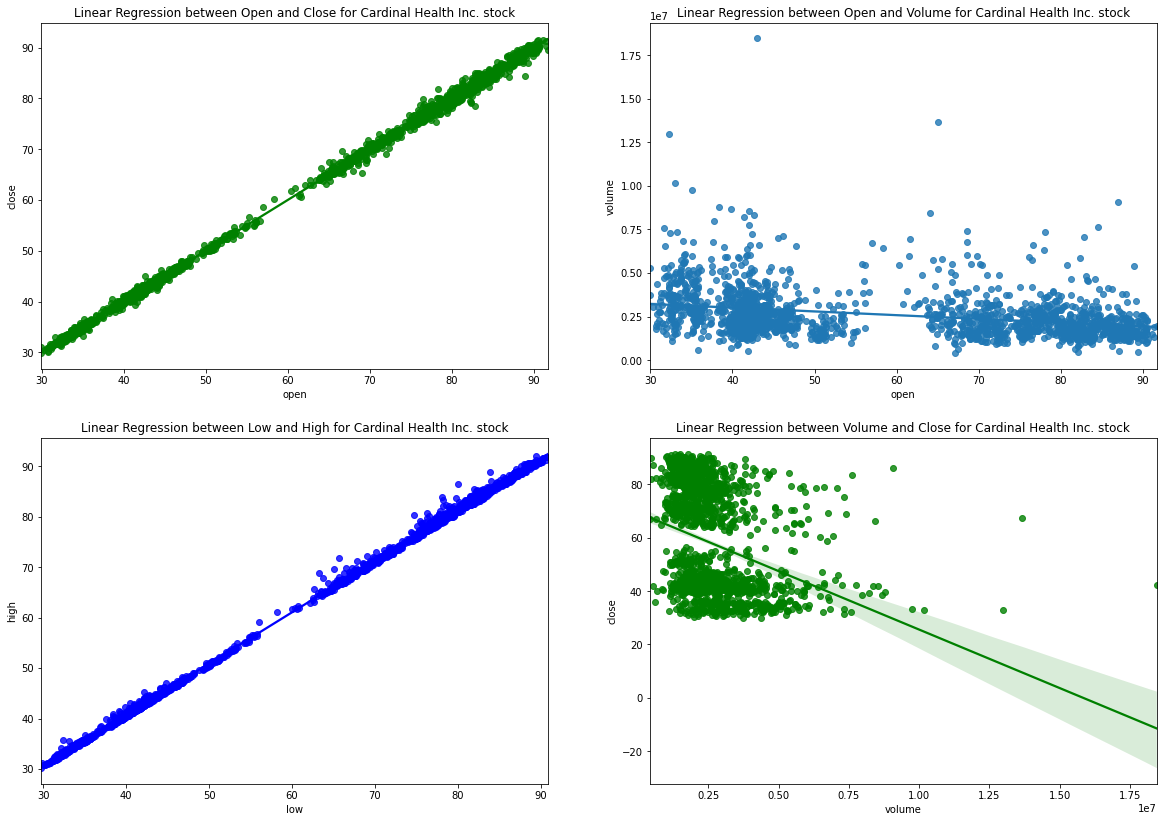

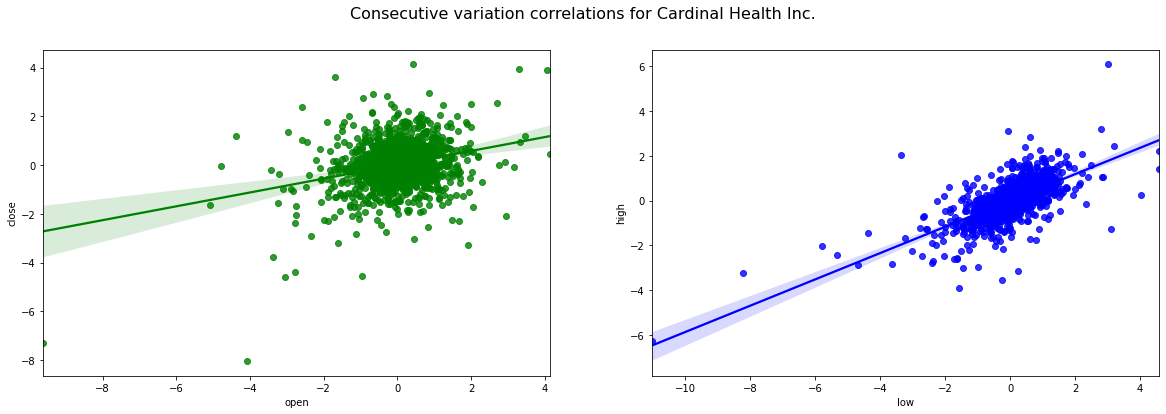

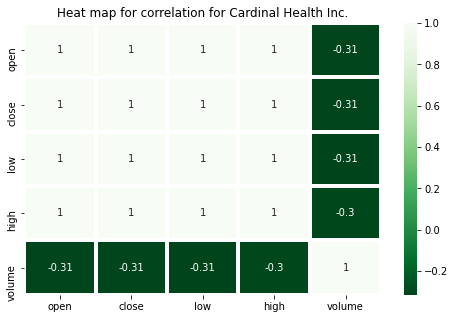

EDA complete for Cardinal Health Inc.
--------------------------------------------------------------------------------------------------------------------------------------------
Stock name - DE
Sector - Industrials
Sub Sector - Construction & Farm Machinery & Heavy Trucks


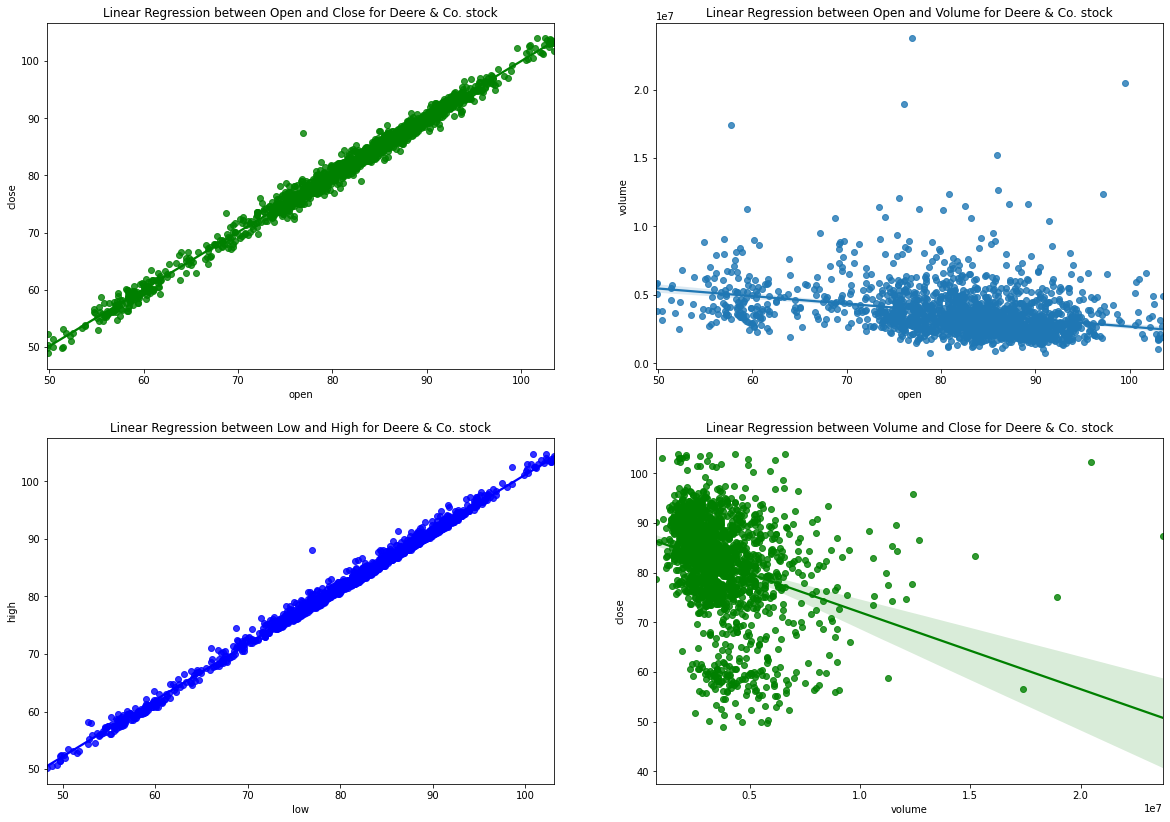

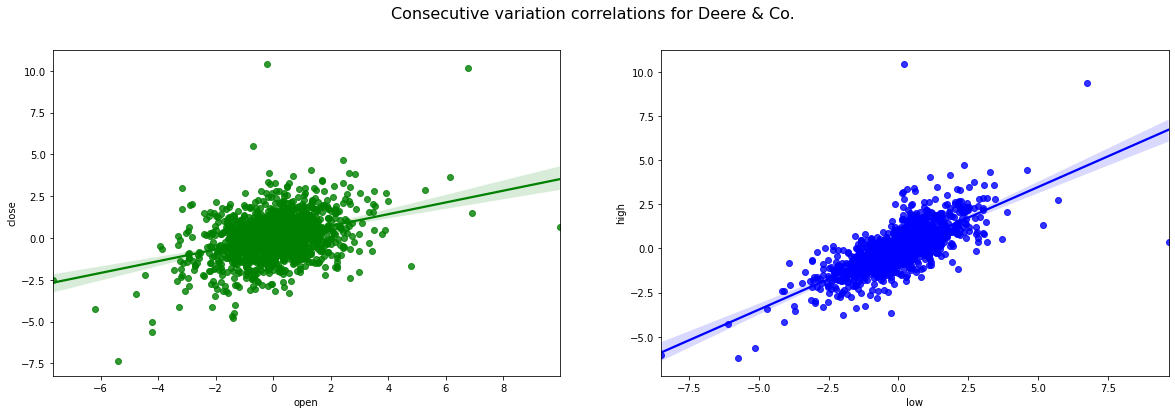

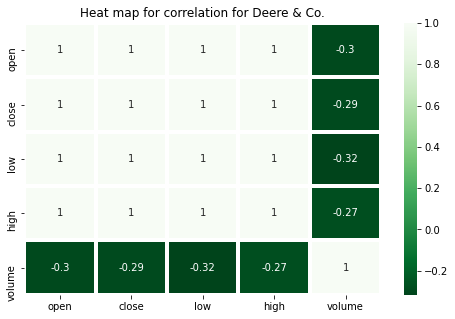

EDA complete for Deere & Co.
--------------------------------------------------------------------------------------------------------------------------------------------
Stock name - MSFT
Sector - Information Technology
Sub Sector - Systems Software


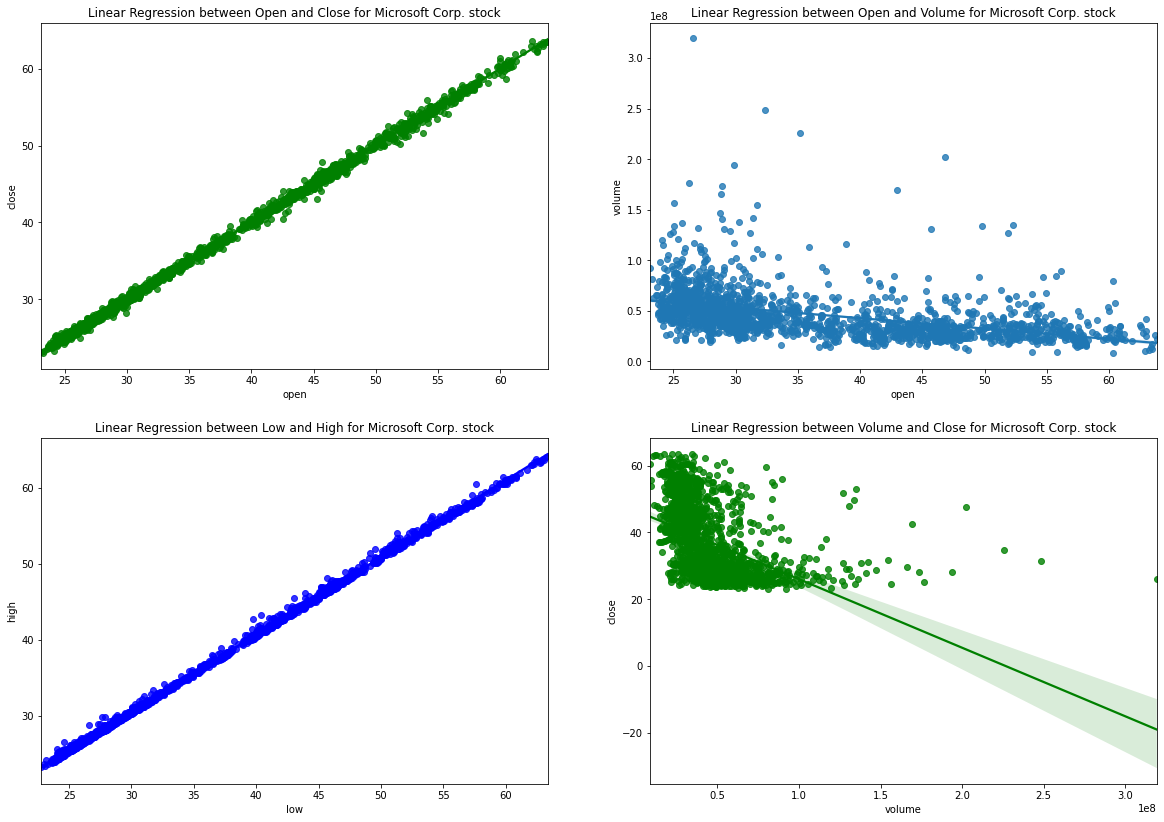

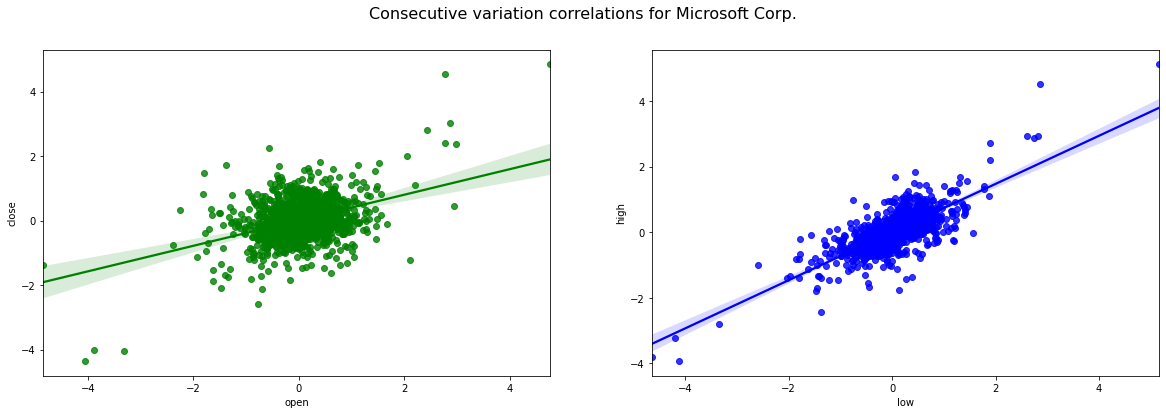

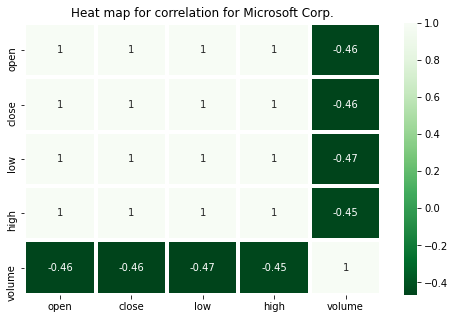

EDA complete for Microsoft Corp.
--------------------------------------------------------------------------------------------------------------------------------------------
Stock name - APD
Sector - Materials
Sub Sector - Industrial Gases


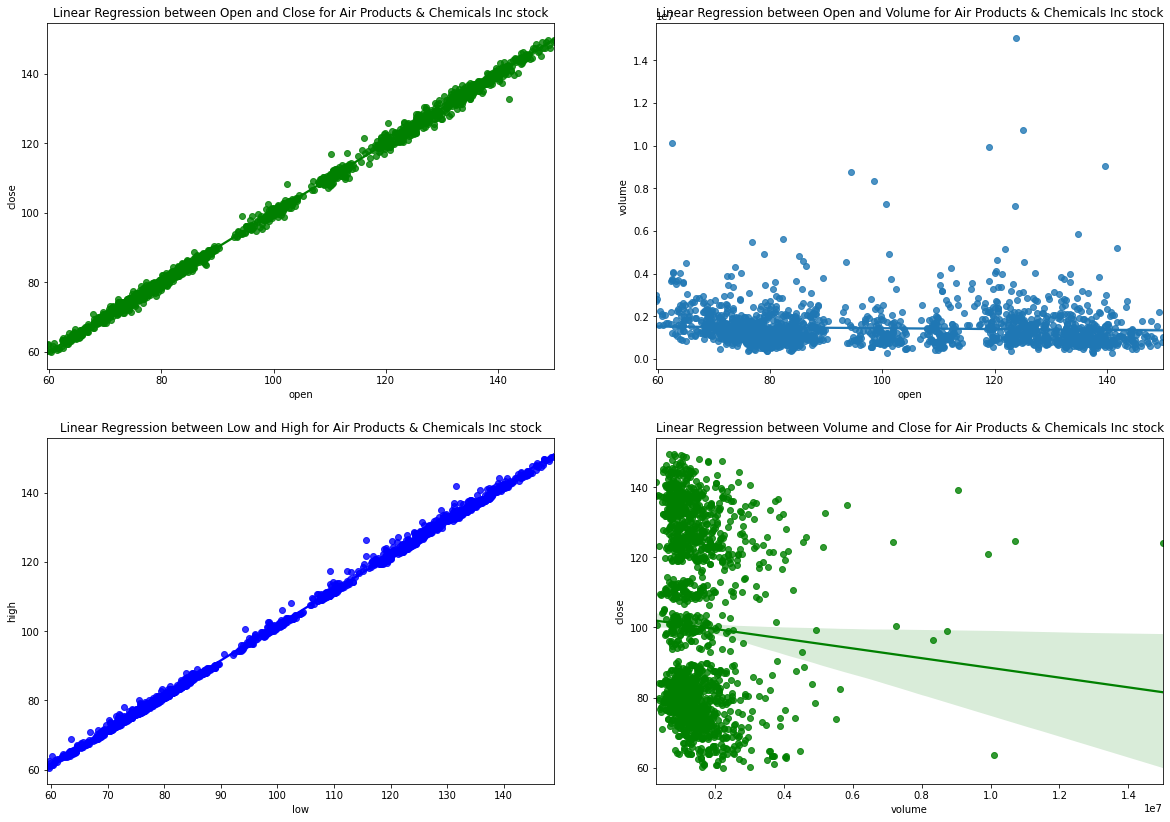

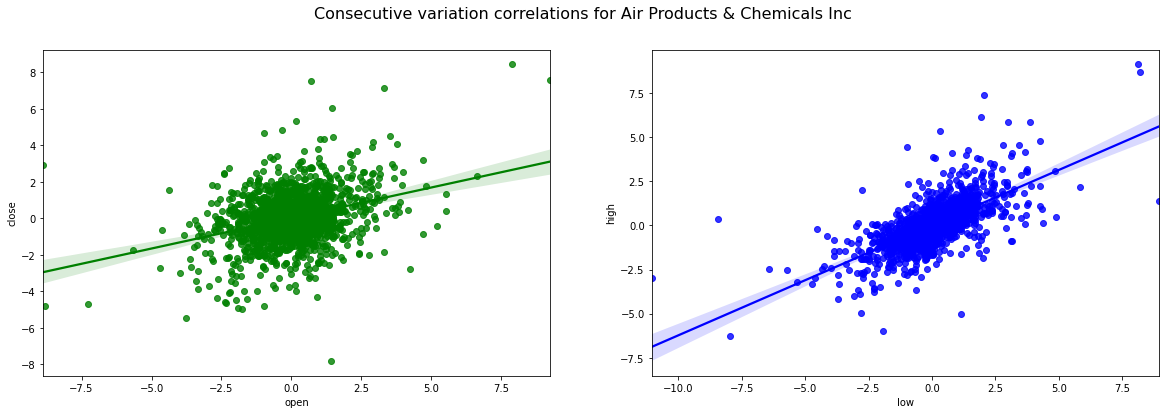

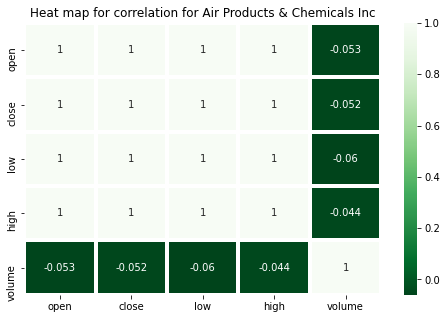

EDA complete for Air Products & Chemicals Inc
--------------------------------------------------------------------------------------------------------------------------------------------
Stock name - O
Sector - Real Estate
Sub Sector - Retail REITs


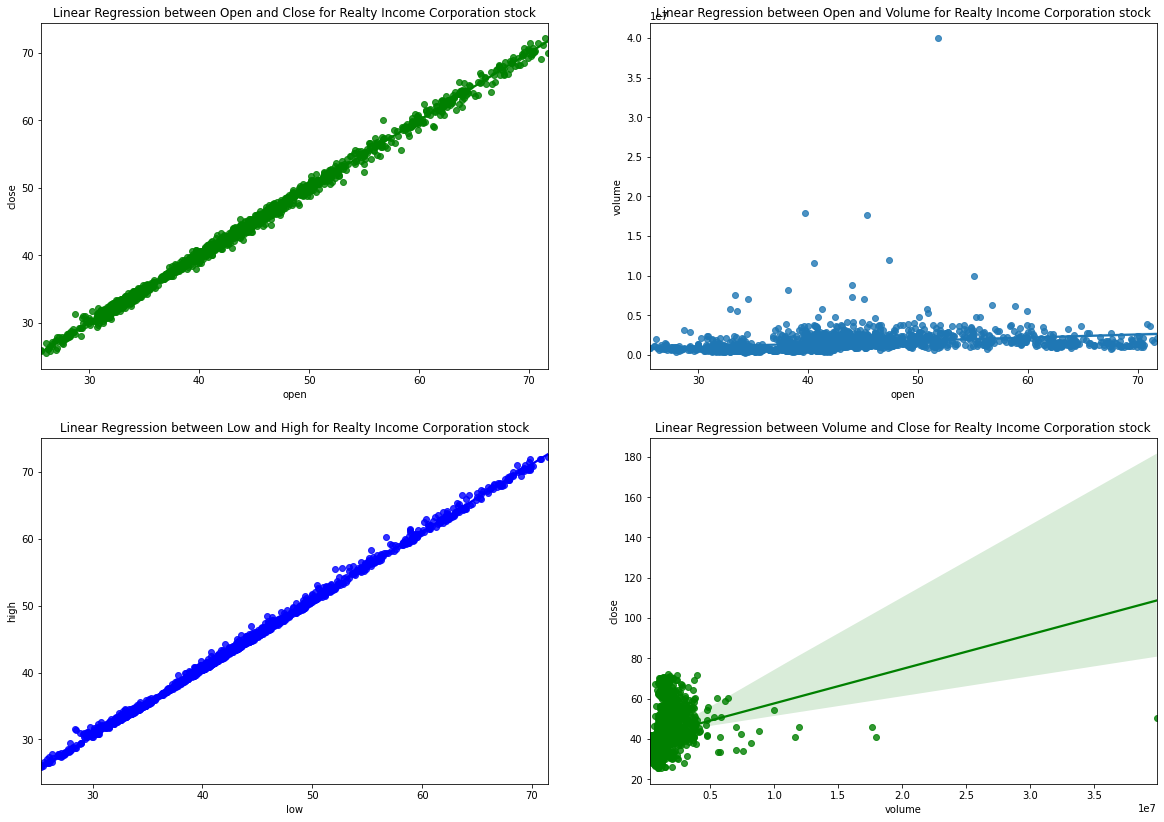

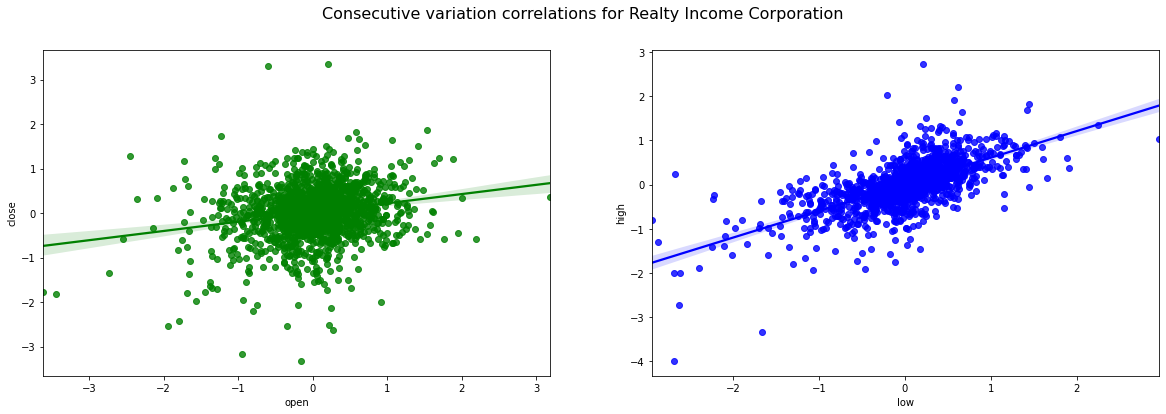

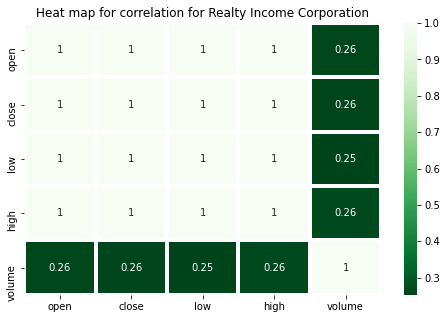

EDA complete for Realty Income Corporation
--------------------------------------------------------------------------------------------------------------------------------------------
Stock name - T
Sector - Telecommunications Services
Sub Sector - Integrated Telecommunications Services


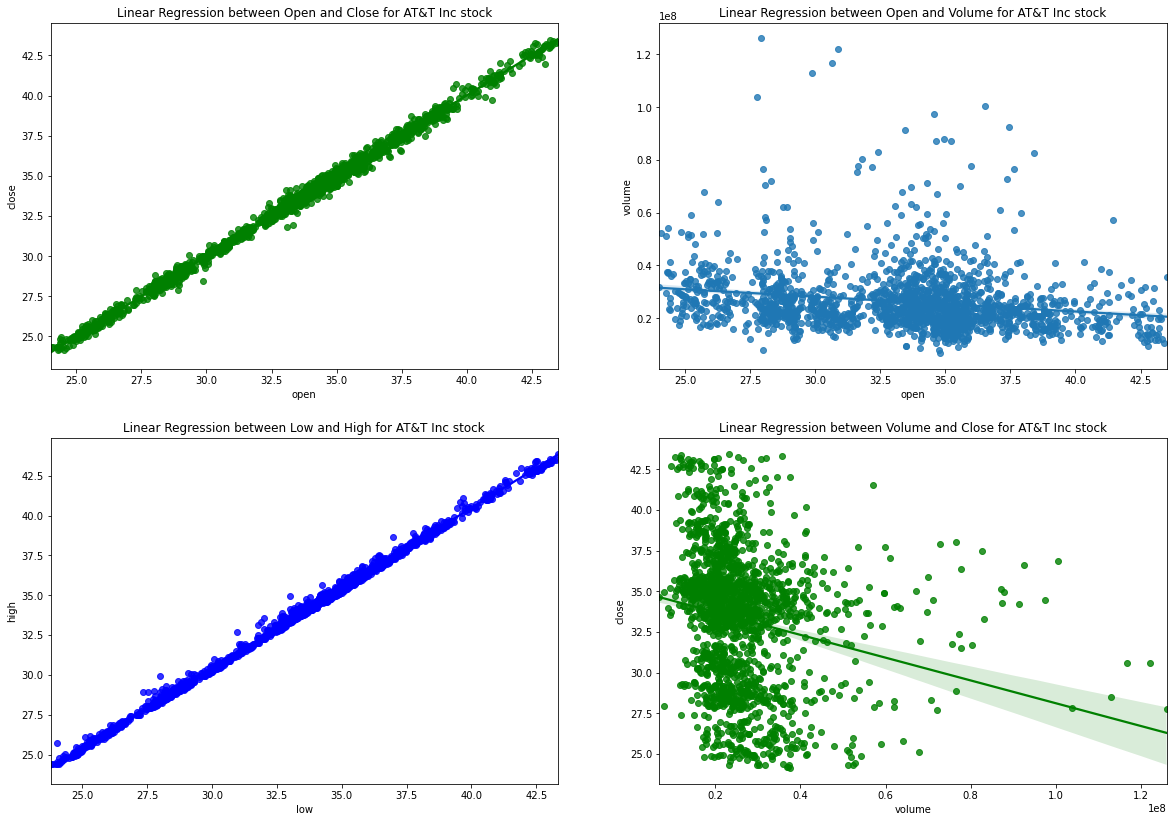

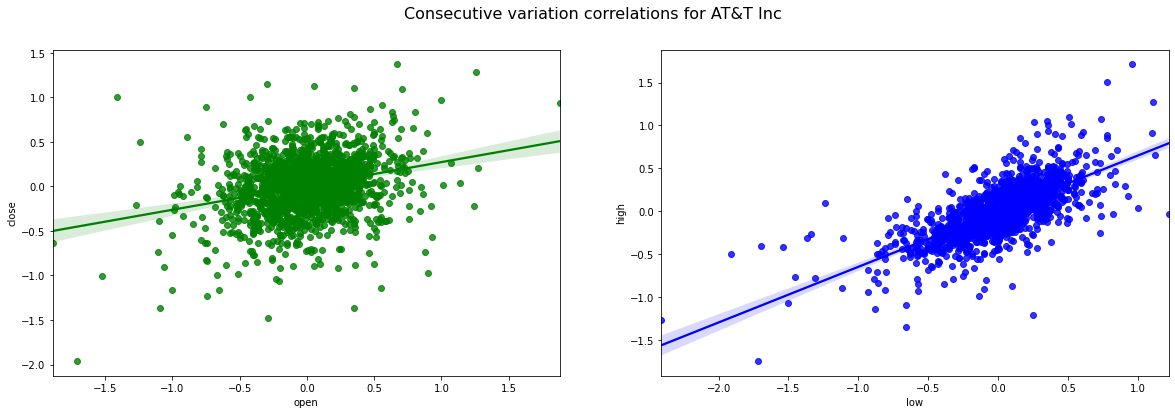

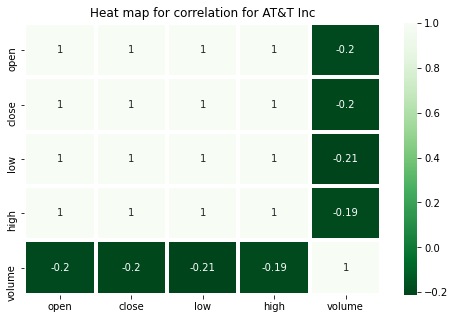

EDA complete for AT&T Inc
--------------------------------------------------------------------------------------------------------------------------------------------
Stock name - EXC
Sector - Utilities
Sub Sector - MultiUtilities


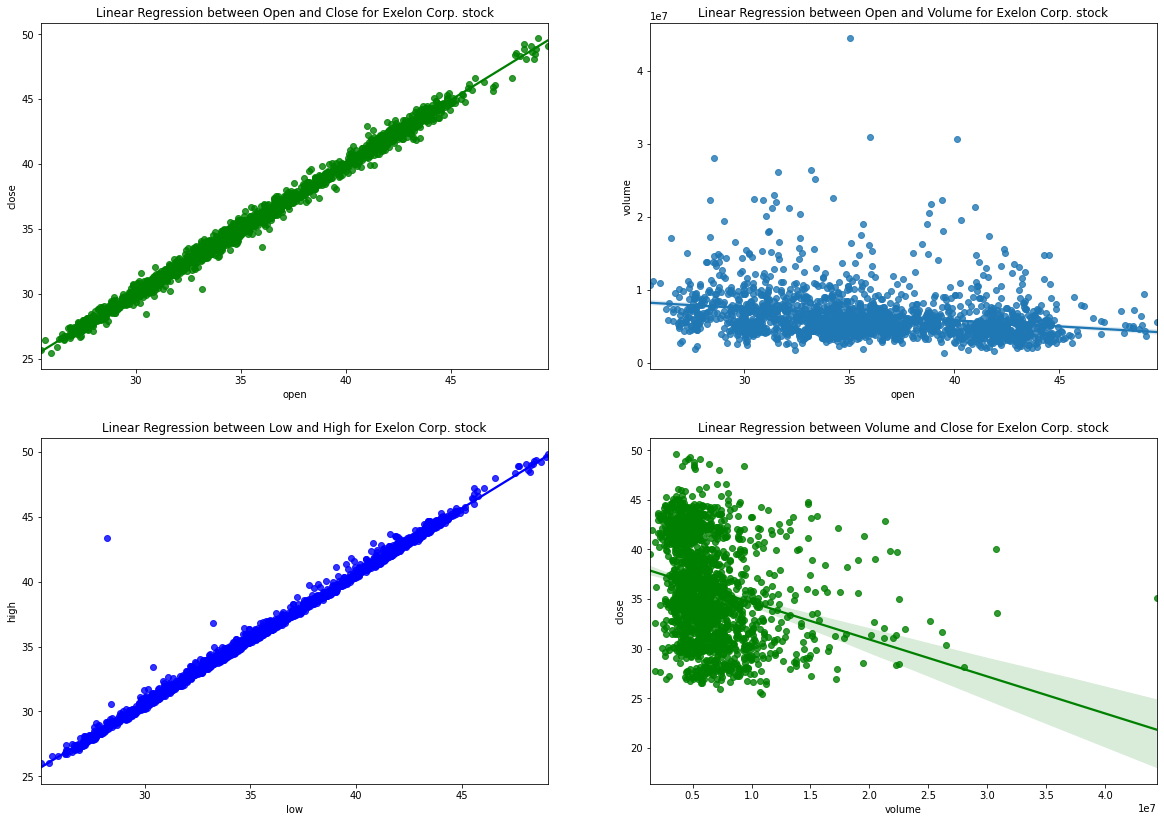

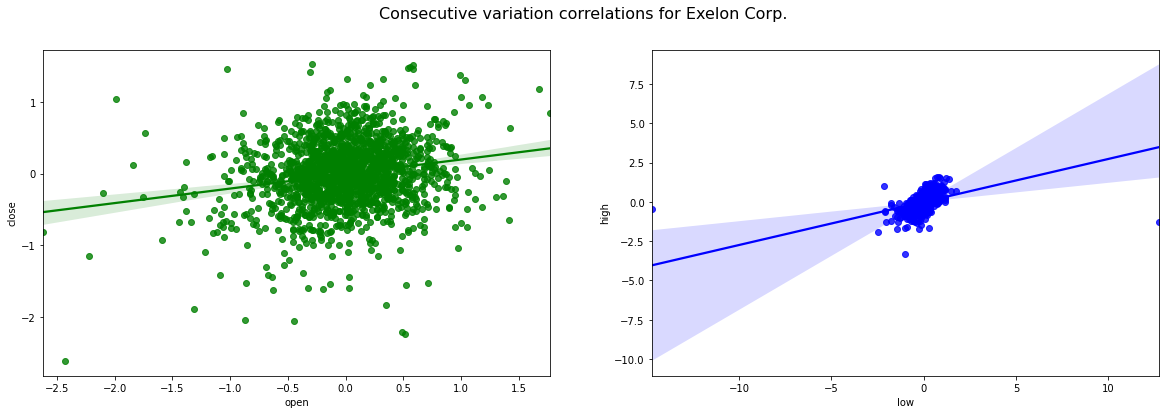

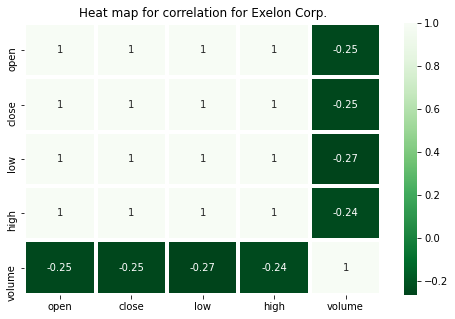

EDA complete for Exelon Corp.
--------------------------------------------------------------------------------------------------------------------------------------------


In [50]:
for each_stock in stocks_for_y.values():
  eda_per_stock(price_split_adj_df,each_stock)

# Dataset creation for regression

In [51]:

# function to create dataset for a given stock and sequence length
def load_data2(stockprices_Dict, seq_len,add_sector,stocks,TA_keynames):
  """Performs processing of data for given stock names to be regression ready.
    
    Args-
        stockprices_Dict - Dataframe dictionary holding dataframe of different stocks with key names as stock names
        seq_len - Integer representing No. of days of history information (i.e. Open, High, Low, Close and volume) to be considered for every data point
        add_sector - Boolean value, based on which sector information from securities file will be included in the data for regression
        stocks - List containing names of stocks (i.e. symbols) to be included in the dataset
        TA_keynames - List holding all the column names of technical indicators in the data frame
    
    Returns-
        dataset - Dataframe with features and output values to be used for regression
  """
  if len(stocks) == 0: #if stocks is empty we will store all stock names in stocks
    stocks = list(stockprices_Dict.keys())

  if len(stocks) == 1: #if we are performing for only one stock then there is no advantage in adding sector as features
    add_sector = False
    
  #Columns which will not be required for regression
  cols_to_removed = ['date','symbol','GICS Sector','GICS Sub Industry','open','high','low']#,'close'] #We are not removing close as we will need this to calculate MSE

  #Columns which will not be required for historical data but might be required for current day data
  cols_required_for_day1 = TA_keynames.copy() #We want to use technical indicators only of day 1 and not previous, hence adding them to a list for removel
  cols_required_for_day1.append('close') #We only want close price of day 1 to to convert predicted log return to close value prediction


  all_stocks_processed_df = []
  for key in stocks:
    tmp_data = stockprices_Dict[key].drop(cols_to_removed,axis=1) #Taking the data of a stock, we will add more features next
    df_list= []
    for i in range(seq_len): #For the number of historical days, we will loop and add relevant information and not all columns

      tmp_df = tmp_data.shift(i+1) #we will do from shift 1 to seq len
      if i != 0: #We will need few columns only for Day 1 i.e. i = 0 hence this condition
        tmp_df.drop(cols_required_for_day1,axis=1,inplace=True)  #Removing cols_required_for_day1 column for all except the immediate previous day
        for each_col in tmp_df.columns:
          if "_corr" in each_col:
            tmp_df.drop(each_col,axis=1,inplace=True) #Removing correlation column for other days except for Day 1
      tmp_df =tmp_df.add_suffix(str(i+1))
      df_list.append(tmp_df) #Addint all historical information to a list
    new_stock_df = pd.concat(df_list,axis=1) #Concatenating all histotical information
    new_stock_df['LogReturnClose'] = tmp_data['LogReturnClose']  #This will be y and the rest will be x values
    new_stock_df['close'] = tmp_data['close']  #We will need this to calculate MSE, this will not be x not y
    
    # Adding sector to be used as additional features
    if add_sector == True:
      new_stock_df['GICS Sector'] = stockprices_Dict[key]['GICS Sector']

    all_stocks_processed_df.append(new_stock_df)  #Saving the data for all stocks

  processed_data_df = pd.concat(all_stocks_processed_df,axis=0) #concatenating all stocks data into one
  processed_data_df.reset_index(drop=True,inplace=True)  #Resetting the dataframe

  #Converting the sector information into categorical data
  if add_sector == True:
    sector_one_hot = pd.get_dummies(processed_data_df['GICS Sector'],prefix="sector")
    processed_data_df.drop('GICS Sector',axis = 1,inplace=True)
    processed_data_df = processed_data_df.join(sector_one_hot)
  return processed_data_df

## Inputs for Dataset

In [52]:
#Below are inputs for create dataset for regression
seq_len = 7   #Number of days to consider for prediction
add_sector = True
stocks = stocks_for_y.values() #These are identified large stocks i.e. one large stock per sector



## Dataset creation

In [53]:
data_for_regression= load_data2(stockprices_Dict, seq_len,add_sector,stocks,TA_keynames)

## Dataset - Training and Test Split

In [54]:
from sklearn.model_selection import train_test_split

training_data_for_regression, test_data_for_regression = train_test_split(data_for_regression, test_size=0.2) #Splitting the data into 80% training and 20% split

# LSTM Neural Network

## Model

In [55]:
def make_nn_model(dropout_rate,learning_rate):
	model = tf.keras.Sequential()
	model.add(tf.keras.layers.LSTM(units=100,return_sequences=True, activation='sigmoid'))
	#model.add(tf.keras.layers.Activation('relu'))
	model.add(tf.keras.layers.Dropout(dropout_rate))
	model.add(tf.keras.layers.Dense(units=64, activation='relu'))
	model.add(tf.keras.layers.Dense(units=1))
	model.add(tf.keras.layers.Activation('linear'))
	opt=tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
	model.compile(loss='mse', optimizer=opt)

	return model

## Inputs for LSTM Neural Network

In [56]:
dropout_rate=0.2
learning_rate=0.0001 
batch_size=256
epochs=200

## Train and predict

In [57]:

cols_to_exclude_from_regression = ['close','close1']  #close will be used for calculating MSE after predictions. close1 will be used to calculate close price form logreturn

train_data = training_data_for_regression.drop(cols_to_exclude_from_regression, axis=1)#Removing columns not required for training
test_data = test_data_for_regression.drop(cols_to_exclude_from_regression, axis=1)#Removing columns not required for prediction


train_data_scaled = train_data.copy() #Creating a copy of training data for scaling

cols_to_be_scaled = []#Some columns like log return are already scaled and hence we will create a list of columns which needs scaling
for each_col in train_data.columns:
  #sector_ are categorical and hence exclusing
  #LogReturn are already between 0 & 1 as they are logarithmic values
  if ((not each_col.startswith("sector_")) and ( not each_col.startswith("LogReturn"))):
    cols_to_be_scaled.append(each_col)

#Creating a dict to save scalers of training data so that they can be be for transforming test data
scalers = {}
for each_col in cols_to_be_scaled:
  scalers[each_col] = MinMaxScaler().fit(train_data_scaled[each_col].values.reshape(-1,1)) #Fitting and saving the sclaer is dictionary
  train_data_scaled[each_col] = scalers[each_col].transform(train_data_scaled[each_col].values.reshape(-1,1)) #Transforming training data

test_data_scaled = test_data.copy()  #Creating a copy of test data for scaling
for each_col in cols_to_be_scaled:
  test_data_scaled[each_col] = scalers[each_col].transform(test_data_scaled[each_col].values.reshape(-1,1)) #Transforming test data


#creating another copy of test_data with close and close1, as we will use this for MSE calculation
test_data_scaled2 = test_data_scaled.copy()
test_data_scaled2['close'] = test_data_for_regression['close'] #Adding close and close1 columns
test_data_scaled2['close1'] = test_data_for_regression['close1']



#print("No. of rows before dropping NA",len(train_data_scaled))
#drop rows with NA values
train_data_scaled.dropna(inplace=True)
test_data_scaled.dropna(inplace=True)
test_data_scaled2.dropna(inplace=True)
#print("No. of rows after dropping NA",len(train_data_scaled))


train_x=train_data_scaled[ train_data_scaled.columns[train_data_scaled.columns != 'LogReturnClose']]
train_y=train_data_scaled['LogReturnClose']

test_x = test_data_scaled[ test_data_scaled.columns[test_data_scaled.columns != 'LogReturnClose']]
test_y= test_data_scaled['LogReturnClose']


#Neural Network - LSTM

#Reshaping arrays to 3 dimensional
train_x = train_x.to_numpy()
test_x = test_x.to_numpy()
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

#Create model
model = make_nn_model(dropout_rate,learning_rate)
starttime = datetime.datetime.now()
print("Training started @ "+starttime.strftime("%d-%m-%Y %H:%M:%S"))

#Training
model.fit(train_x, train_y,batch_size=batch_size,epochs=epochs)# Code - Upgrade -- Adding batch_size reduces the training time from 3 minutes to 49 seconds
endtime = datetime.datetime.now()
print("Training ended @ "+endtime.strftime("%d-%m-%Y %H:%M:%S"))
print("Time taken for training :",endtime-starttime)

#Prediction
y_test_pred = model.predict(test_x)[:,0,0]

#Calculate predicted close price from predicted log return of close price
y_test_pred_close = np.exp(y_test_pred)*test_data_scaled2['close1']

# Calculate MSE of log return close price
mse_value = mean_squared_error(test_y, y_test_pred)
print('Mean squared error of log return close price - %.8f for LSTM Neural Network'% (mse_value))

# Calculate MSE of close price
mse_value = mean_squared_error(test_data_scaled2['close'], y_test_pred_close)
print('Mean squared error of close price - %.8f for for LSTM Neural Network'% (mse_value))


Training started @ 18-11-2020 01:32:46
Epoch 1/200
55/55 [==============================] - 0s 5ms/step - loss: 0.0163
Epoch 2/200
55/55 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 3/200
55/55 [==============================] - 0s 5ms/step - loss: 0.0069
Epoch 4/200
55/55 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 5/200
55/55 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 6/200
55/55 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 7/200
55/55 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 8/200
55/55 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 9/200
55/55 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 10/200
55/55 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 11/200
55/55 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 12/200
55/55 [==============================] - 0s 5ms/step - loss: 8.970